In [38]:
# general imports
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib.colors import ListedColormap
import seaborn as sns

# from our documents
import OurFunctions as of

# from Scikit Learn library
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, make_scorer, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import plot_tree
from sklearn.calibration import CalibratedClassifierCV

# from Imb Learn
from imblearn.over_sampling import SMOTENC, SMOTE



In [39]:
ASD_phenotypic_original = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_phenotypic.csv'))
ASD_phenotypic = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_phenotypic_preprocessed.csv'))
ASD_diagnosis = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_clinical.csv'))

# CLASSIFICATION

First of all, we split the data into train set and test set, to be sure that our classifier is evaluated on data that it had never seen before.

In [40]:
#ASD_phenotypic = ASD_phenotypic.drop(columns=["SITE_ID", "VIQ_TEST_TYPE", "FIQ_TEST_TYPE", "PIQ_TEST_TYPE"])
ASD_phenotypic = ASD_phenotypic.drop(columns=["SITE_ID"])
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(ASD_phenotypic, ASD_diagnosis['DX_GROUP'], test_size=0.3, random_state=42)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (467, 10)
Test set size: (201, 10)


I want to check the balance between classes for each set, to  be sure we are training the classifier using a good split.

In [41]:
class_counts_test = y_test.value_counts(normalize=True)
class_counts_train = y_train.value_counts(normalize=True)
class_count_train_num = y_train.value_counts()

# Stampa il conteggio delle classi per DX_GROUP
print("Class proportions for:")
print("- test set: " + str(class_counts_test))
print("- train set: " + str(class_counts_train))
print("Num subjects involved per "+ str(class_count_train_num))

Class proportions for:
- test set: DX_GROUP
1    0.60199
2    0.39801
Name: proportion, dtype: float64
- train set: DX_GROUP
1    0.603854
2    0.396146
Name: proportion, dtype: float64
Num subjects involved per DX_GROUP
1    282
2    185
Name: count, dtype: int64


# General pipeline

To achieve a more reliable accuracy score we use k-fold cross validation. In this way we are performing the training on different train and validation fold and we avoid to have a better accuracy based only on the subjects we selected.

In [42]:
def general_pipeline(dataset, target, classifier, encoder = True, scaler = True, parameters_grid_search = None, cv = None, feature_selector=False):

    # Definizione delle metriche da utilizzare come scoring
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1_score': make_scorer(f1_score)
    }

    # Preprocess to make on the train data may include
    # - normalization of the numerical columns
    # - one hot encoding on the categorical columns
    
    categorical_columns = dataset.select_dtypes(include=['object']).columns

    if not encoder:
        transformers = [('num', RobustScaler(), ~dataset.columns.isin(categorical_columns))]
    elif not scaler:
        transformers = [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)]
    elif not encoder and not scaler:
        transformers = []
    else:
        transformers=[
            ('num', RobustScaler(), ~dataset.columns.isin(categorical_columns)),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ]

    preprocessor = ColumnTransformer(transformers=transformers)

    if isinstance(classifier, KNeighborsClassifier):
        parameter_type = 'classifier__n_neighbors'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  # Valori di n_neighbors da esplorare
        else:
            parameters = {parameter_type: [3, 5, 7, 9, 11]}  # Valori di n_neighbors da esplorare

        feature_selector_type = SFS(classifier)
        selector_parameter = 'feature_selection__n_features_to_select'
        # per default is forward, but if you need to change --> parameters.update({'sfs__direction': ['forward']})
        #feature_selector_type = SelectKBest(score_func=f_classif)
        #selector_parameter = 'feature_selection__k'
        

    if isinstance(classifier, RandomForestClassifier):
        parameter_type = 'classifier__n_estimators'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  
        else:
            parameters = {parameter_type: [10, 50, 200, 500, 1000]} 

        feature_selector_type = RFE(estimator=classifier)
        selector_parameter = 'feature_selection__n_features_to_select'

    if isinstance(classifier, CalibratedClassifierCV):
        parameter_type = 'classifier__estimator__C'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  
        else:
            parameters = {parameter_type: [1]}  

        #feature_selector_type = SelectFromModel(LinearSVC(penalty='l1', dual=False))
        #selector_parameter = 'feature_selection__max_features'
        feature_selector_type = RFE(estimator=LinearSVC(dual=False))
        selector_parameter = 'feature_selection__n_features_to_select'

    if feature_selector:
        # Initialize RFE with the fitted classifier

        pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', feature_selector_type),
        ('classifier', classifier)  
        ])

        parameters.update({selector_parameter: list(range(1, 23+1))})
        
    else:
    # We define the pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier),
            ])

    if cv:
        k_folds = cv
    else:
        k_folds = 5

    # Creazione dell'oggetto GridSearchCV
    grid_search = GridSearchCV(pipeline, parameters, cv= k_folds, scoring=scoring, refit='accuracy')

    # Esecuzione della ricerca a griglia
    grid_search.fit(dataset, target)

    # Visualizzazione dei risultati
    print("Risultati della cross-validation per tutte le combinazioni di iperparametri:")

    means_accuracy = grid_search.cv_results_['mean_test_accuracy']
    stds_accuracy = grid_search.cv_results_['std_test_accuracy']
    means_precision = grid_search.cv_results_['mean_test_precision']
    means_recall = grid_search.cv_results_['mean_test_recall']
    means_f1_score = grid_search.cv_results_['mean_test_f1_score']
    params = grid_search.cv_results_['params']

    for mean_acc, std_acc, mean_prec, mean_rec, mean_f1, params in zip(means_accuracy, stds_accuracy, means_precision, means_recall, means_f1_score, params):
        print(f"Parametri: {params}, Accuratezza media: {mean_acc:.3f} (±{std_acc:.3f}), Precision media: {mean_prec:.3f}, Richiamo medio: {mean_rec:.3f}, F1-score medio: {mean_f1:.3f}")

    best_model = grid_search.best_estimator_
    best_parameter = grid_search.best_params_[parameter_type]
    best_accuracy = grid_search.best_score_
    print("\nMiglior parametro trovato:")
    print(best_parameter)
    print("Accuratezza media con il miglior parametro:", best_accuracy)

    if feature_selector:
        # Get the support mask and selected feature names from the preprocessed data
        selected_mask = best_model.named_steps['feature_selection'].get_support()
        feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
        selected_features = feature_names[selected_mask]
        
        print("\nSelected features are:")
        print(f"Number of selected features: {len(selected_features)}")
        print("Selected features:", selected_features)

        non_selected_mask = ~selected_mask
        non_selected_features = feature_names[non_selected_mask]

        print("\nNon selected features are:")
        print(f"Number of non selected features: {len(non_selected_features)}")
        print("Selected features:", non_selected_features)

        return best_model, best_parameter, best_accuracy, selected_features
        
    return best_model, best_parameter, best_accuracy, None
    

In [43]:
categorical_columns = X_train.select_dtypes(include=['object']).columns
categorical_features = categorical_columns.tolist()

# Inizializza l'oggetto SMOTE-NC specificando gli indici delle colonne categoriche
sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

# Applica SMOTE-NC per generare nuovi esempi sintetici
X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)

# Stampa la distribuzione delle classi dopo l'applicazione di SMOTE-NC
print(pd.Series(Y_SMOTE).value_counts(normalize=True))
print("Num subjects involved per")
print(pd.Series(Y_SMOTE).value_counts())

#sampler = SMOTE(random_state=42) --> in case we want to use only numeric

# Applica SMOTE-NC per generare nuovi esempi sintetici
X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)

# Stampa la distribuzione delle classi dopo l'applicazione di SMOTE-NC
print(pd.Series(Y_SMOTE).value_counts(normalize=True))
print("Num subjects involved per")
print(pd.Series(Y_SMOTE).value_counts())

DX_GROUP
1    0.5
2    0.5
Name: proportion, dtype: float64
Num subjects involved per
DX_GROUP
1    282
2    282
Name: count, dtype: int64
DX_GROUP
1    0.5
2    0.5
Name: proportion, dtype: float64
Num subjects involved per
DX_GROUP
1    282
2    282
Name: count, dtype: int64


# K-NEAREST NEIGHBOOR

In [44]:
classifier = KNeighborsClassifier()
knn_model, knn_parameter, knn_accuracy, _= general_pipeline(X_SMOTE, Y_SMOTE, classifier)


Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parametri: {'classifier__n_neighbors': 3}, Accuratezza media: 0.865 (±0.021), Precision media: 0.950, Richiamo medio: 0.773, F1-score medio: 0.851
Parametri: {'classifier__n_neighbors': 5}, Accuratezza media: 0.871 (±0.014), Precision media: 0.974, Richiamo medio: 0.763, F1-score medio: 0.855
Parametri: {'classifier__n_neighbors': 7}, Accuratezza media: 0.858 (±0.027), Precision media: 0.968, Richiamo medio: 0.741, F1-score medio: 0.839
Parametri: {'classifier__n_neighbors': 9}, Accuratezza media: 0.846 (±0.028), Precision media: 0.958, Richiamo medio: 0.724, F1-score medio: 0.823
Parametri: {'classifier__n_neighbors': 11}, Accuratezza media: 0.848 (±0.024), Precision media: 0.976, Richiamo medio: 0.713, F1-score medio: 0.823

Miglior parametro trovato:
5
Accuratezza media con il miglior parametro: 0.8705910240202275


In [45]:
# Valutazione del modello sui dati di test
y_pred = knn_model.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")



Valutazione del modello sui dati di test:
Accuratezza: 0.876
Precisione: 0.936
Richiamo: 0.851
F1-score: 0.892


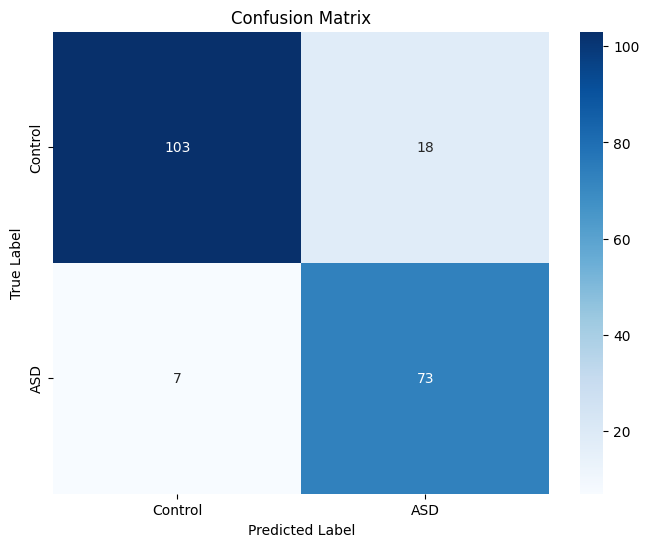

In [46]:
# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## Random Forest

To use the Random Forest classifier, I need to have only numerical features, so we will use one-hot-encoding to turn the categorical features (which aren't ordinal) into numerical features. It's not necessary to perform any normalization, but as we want to compare the performance of this classifier with others that use normalization, we will also use normalized data to train this classifier (it's not harmfull for the Random Forest Classifier).

In [47]:
classifier = RandomForestClassifier(random_state=1234)
rf_model, rf_parameter, rf_accuracy, _ = general_pipeline(X_SMOTE, Y_SMOTE, classifier)

Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parametri: {'classifier__n_estimators': 10}, Accuratezza media: 0.920 (±0.019), Precision media: 0.935, Richiamo medio: 0.904, F1-score medio: 0.919
Parametri: {'classifier__n_estimators': 50}, Accuratezza media: 0.920 (±0.017), Precision media: 0.953, Richiamo medio: 0.886, F1-score medio: 0.917
Parametri: {'classifier__n_estimators': 200}, Accuratezza media: 0.922 (±0.019), Precision media: 0.956, Richiamo medio: 0.886, F1-score medio: 0.919
Parametri: {'classifier__n_estimators': 500}, Accuratezza media: 0.920 (±0.020), Precision media: 0.956, Richiamo medio: 0.883, F1-score medio: 0.917
Parametri: {'classifier__n_estimators': 1000}, Accuratezza media: 0.922 (±0.027), Precision media: 0.963, Richiamo medio: 0.879, F1-score medio: 0.918

Miglior parametro trovato:
200
Accuratezza media con il miglior parametro: 0.9220132743362832


In [48]:
# Valutazione del modello sui dati di test
y_pred = rf_model.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")



Valutazione del modello sui dati di test:
Accuratezza: 0.950
Precisione: 0.951
Richiamo: 0.967
F1-score: 0.959


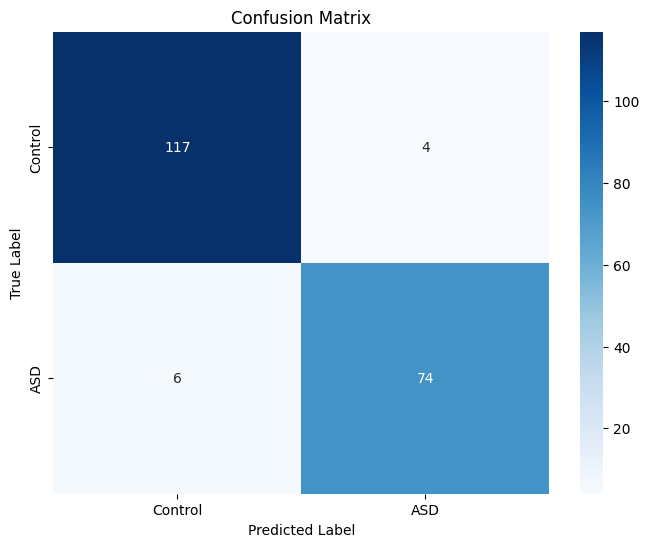

In [49]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Support vector machine

In [50]:
classifier = CalibratedClassifierCV(LinearSVC(dual=False))
svc_model, svc_parameter, svc_accuracy, _ = general_pipeline(X_SMOTE, Y_SMOTE, classifier)

Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parametri: {'classifier__estimator__C': 1}, Accuratezza media: 0.901 (±0.021), Precision media: 0.960, Richiamo medio: 0.837, F1-score medio: 0.894

Miglior parametro trovato:
1
Accuratezza media con il miglior parametro: 0.9007743362831858


In [51]:
# Valutazione del modello sui dati di test
y_pred = svc_model.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")



Valutazione del modello sui dati di test:
Accuratezza: 0.925
Precisione: 0.965
Richiamo: 0.909
F1-score: 0.936


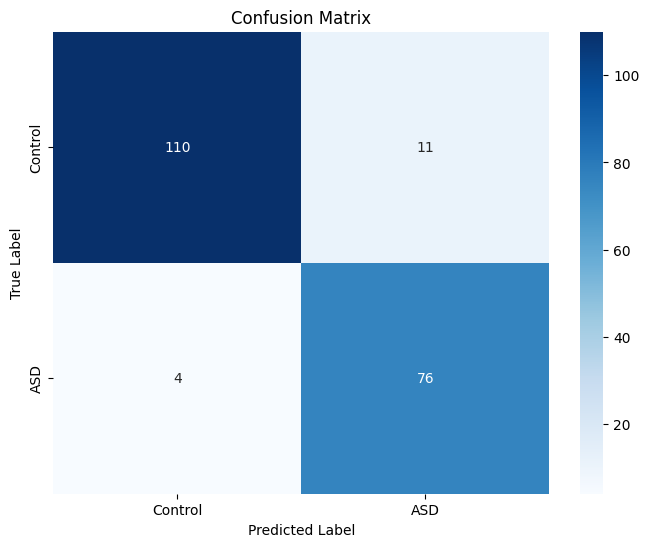

In [52]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Comparison Between Classifiers

In [53]:
# Define a function to evaluate the AUC-ROC for a given model
def evaluate_roc_auc(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    auc_roc = roc_auc_score(y_test, y_proba)
    return auc_roc

knn_auc_roc = evaluate_roc_auc(knn_model, X_test, y_test)
rf_auc_roc = evaluate_roc_auc(rf_model, X_test, y_test)
svc_auc_roc = evaluate_roc_auc(svc_model, X_test, y_test)

# Print the results
print("K-Nearest Neighbors Classifier AUC-ROC:", knn_auc_roc)
print("Random Forest Classifier AUC-ROC:", rf_auc_roc)
print("Support vector Classifier AUC-ROC:", svc_auc_roc)


K-Nearest Neighbors Classifier AUC-ROC: 0.9388946280991736
Random Forest Classifier AUC-ROC: 0.983987603305785
Support vector Classifier AUC-ROC: 0.9760330578512396


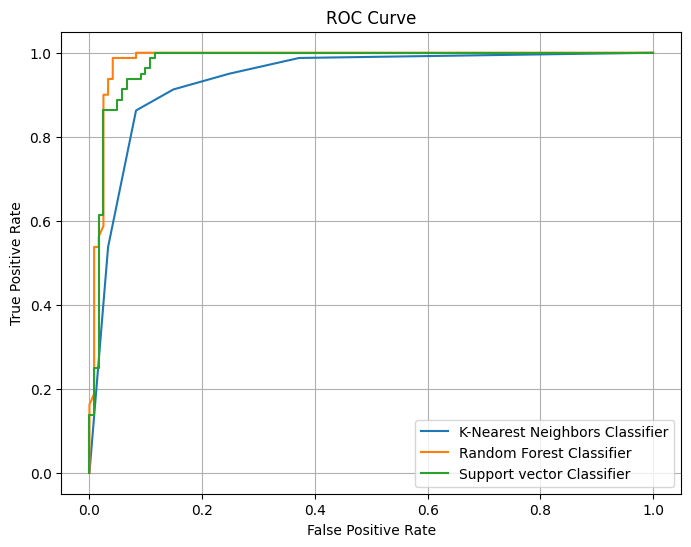

In [54]:
# Define a function to plot the ROC curve for a given model
def plot_roc_curve(model, X_test, y_test, model_name):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=model_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

# Plot ROC curve for both models
y_test_binary = (y_test == 2).astype(int)

plt.figure(figsize=(8, 6))
plot_roc_curve(knn_model, X_test, y_test_binary, 'K-Nearest Neighbors Classifier')
plot_roc_curve(rf_model, X_test, y_test_binary, 'Random Forest Classifier')
plot_roc_curve(svc_model, X_test, y_test_binary, 'Support vector Classifier')
plt.show()


# Feature selection

In [55]:
classifier = KNeighborsClassifier()

fs_KNN, fs_KNN_parameter, fs_KNN_accuracy, fs_KNN_selected_features = general_pipeline(X_SMOTE, Y_SMOTE, classifier, parameters_grid_search = [9], feature_selector=True)

KeyboardInterrupt: 

In [ ]:
# Valutazione del modello sui dati di test
y_pred = fs_KNN.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")


Valutazione del modello sui dati di test:
Accuratezza: 0.905
Precisione: 0.964
Richiamo: 0.876
F1-score: 0.918


In [ ]:
classifier = RandomForestClassifier(random_state=1234)

fs_RF, fs_RF_parameter, fs_RF_accuracy, fs_RF_selected_features = general_pipeline(X_SMOTE, Y_SMOTE, classifier, parameters_grid_search = [10], feature_selector=True)

Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parametri: {'classifier__n_estimators': 10, 'feature_selection__n_features_to_select': 1}, Accuratezza media: 0.851 (±0.020), Precision media: 1.000, Richiamo medio: 0.702, F1-score medio: 0.824
Parametri: {'classifier__n_estimators': 10, 'feature_selection__n_features_to_select': 2}, Accuratezza media: 0.910 (±0.015), Precision media: 0.951, Richiamo medio: 0.869, F1-score medio: 0.905
Parametri: {'classifier__n_estimators': 10, 'feature_selection__n_features_to_select': 3}, Accuratezza media: 0.887 (±0.024), Precision media: 0.901, Richiamo medio: 0.872, F1-score medio: 0.885
Parametri: {'classifier__n_estimators': 10, 'feature_selection__n_features_to_select': 4}, Accuratezza media: 0.903 (±0.019), Precision media: 0.931, Richiamo medio: 0.872, F1-score medio: 0.900
Parametri: {'classifier__n_estimators': 10, 'feature_selection__n_features_to_select': 5}, Accuratezza media: 0.904 (±0.029), Precision media: 

In [ ]:
# Valutazione del modello sui dati di test
y_pred = fs_RF.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")


Valutazione del modello sui dati di test:
Accuratezza: 0.935
Precisione: 0.929
Richiamo: 0.967
F1-score: 0.947


In [ ]:
classifier = CalibratedClassifierCV(LinearSVC(dual=False))

fs_SVM, fs_SVM_parameter, fs_SVM_accuracy, fs_SVM_selected_features = general_pipeline(X_SMOTE, Y_SMOTE, classifier, feature_selector=True)

Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parametri: {'classifier__estimator__C': 1, 'feature_selection__n_features_to_select': 1}, Accuratezza media: 0.796 (±0.116), Precision media: 0.978, Richiamo medio: 0.595, F1-score medio: 0.712
Parametri: {'classifier__estimator__C': 1, 'feature_selection__n_features_to_select': 2}, Accuratezza media: 0.837 (±0.025), Precision media: 0.985, Richiamo medio: 0.685, F1-score medio: 0.807
Parametri: {'classifier__estimator__C': 1, 'feature_selection__n_features_to_select': 3}, Accuratezza media: 0.839 (±0.010), Precision media: 0.961, Richiamo medio: 0.709, F1-score medio: 0.814
Parametri: {'classifier__estimator__C': 1, 'feature_selection__n_features_to_select': 4}, Accuratezza media: 0.832 (±0.024), Precision media: 0.946, Richiamo medio: 0.709, F1-score medio: 0.809
Parametri: {'classifier__estimator__C': 1, 'feature_selection__n_features_to_select': 5}, Accuratezza media: 0.849 (±0.020), Precision media: 0.977

In [ ]:
# Valutazione del modello sui dati di test
y_pred = fs_SVM.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")


Valutazione del modello sui dati di test:
Accuratezza: 0.925
Precisione: 0.965
Richiamo: 0.909
F1-score: 0.936


# Outliers detection

In [ ]:
ASD_phenotypic.describe()

,AGE_AT_SCAN,SEX,FIQ,VIQ,PIQ,ADI_R_VERBAL_TOTAL_BV,ADOS_TOTAL
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,16.276463,1.118263,107.514649,106.976190,106.287425,11.812874,9.679641
std,7.183633,0.323162,15.333876,15.782631,16.113020,5.027005,3.751550
min,6.470000,1.000000,58.642857,54.888889,37.000000,4.000000,0.000000
25%,11.658575,1.000000,97.000000,97.000000,96.000000,8.000000,7.000000
50%,14.260000,1.000000,107.428571,108.000000,107.000000,9.000000,9.000000
75%,18.495100,1.000000,119.000000,118.000000,118.000000,16.000000,11.000000
max,64.000000,2.000000,148.000000,168.768116,157.000000,26.000000,22.000000


In [ ]:
#outlier_subjects.describe()

In [ ]:
'''from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
outliers = X_reduced[ASD_phenotypic_outliers['outlier'] == -1]

lof_scores = lof.negative_outlier_factor_

# Plot the data points with color indicating LOF scores
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=-lof_scores, cmap='hot_r', edgecolor='k', label='Inliers')
plt.colorbar(label='LOF Score')
plt.scatter(outliers[:, 0], outliers[:, 1], c='blue', edgecolor='k', marker='x', s=100, label='Outliers')  # Highlight outliers
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Data points with LOF scores')
plt.show()'''


"from sklearn.decomposition import PCA\nimport matplotlib.pyplot as plt\n\n# Perform PCA for dimensionality reduction\npca = PCA(n_components=2)\nX_reduced = pca.fit_transform(X)\noutliers = X_reduced[ASD_phenotypic_outliers['outlier'] == -1]\n\nlof_scores = lof.negative_outlier_factor_\n\n# Plot the data points with color indicating LOF scores\nplt.figure(figsize=(10, 6))\nplt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=-lof_scores, cmap='hot_r', edgecolor='k', label='Inliers')\nplt.colorbar(label='LOF Score')\nplt.scatter(outliers[:, 0], outliers[:, 1], c='blue', edgecolor='k', marker='x', s=100, label='Outliers')  # Highlight outliers\nplt.xlabel('PCA Component 1')\nplt.ylabel('PCA Component 2')\nplt.title('Data points with LOF scores')\nplt.show()"

Let's see the changes in the data distribution per each feature

In [ ]:
'''ASD_phenotypic_without_outliers = ASD_phenotypic[ASD_phenotypic_outliers['outlier'] == 1]
ASD_diagnosis_without_outliers = ASD_diagnosis[ASD_phenotypic_outliers['outlier'] == 1]
of.plot_distributions(ASD_phenotypic_without_outliers)'''

"ASD_phenotypic_without_outliers = ASD_phenotypic[ASD_phenotypic_outliers['outlier'] == 1]\nASD_diagnosis_without_outliers = ASD_diagnosis[ASD_phenotypic_outliers['outlier'] == 1]\nof.plot_distributions(ASD_phenotypic_without_outliers)"

In [ ]:
#of.plot_distributions(ASD_phenotypic)

let's see if this make a better training

# Outlier Detection

In [ ]:
contamination_factor = [0.001, 0.0015, 0.006, 0.008]

In [ ]:
def outlier_detector(dataset, diagnosis, contamination_factor):
    dataset_outliers = dataset.select_dtypes(include=[np.number])
    X = dataset_outliers.values

    # Initialize Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=10, contamination=contamination_factor)  # Adjust parameters as needed
    '''n_neighbors | if too small: model sensible to noise and random outliers
                 if too large: diculties in local outliers detection, in particular if in absence oa a uniform distribution
       contamination | data portion expected as outliers'''
    # Fit the model and predict outliers
    outliers = lof.fit_predict(X)

    # Print number of detected outliers
    print(f"___________________\nNumber of outliers detected: {np.sum(outliers == -1)}")

    # outliers == -1 indicates outliers, 1 indicates inliers
    dataset_outliers['outlier'] = outliers

    outlier_subjects = dataset_outliers[dataset_outliers['outlier'] == -1]

    pd.set_option('display.max_columns', None); outlier_subjects.T

    dataset_without_outliers = dataset[dataset_outliers['outlier'] == 1]
         
    diagnosis_without_outliers = diagnosis[dataset_outliers['outlier'] == 1]

    return dataset_without_outliers, diagnosis_without_outliers

In [ ]:
def evaluate_model(X_SMOTE, Y_SMOTE, X_test, y_test, classifier):
    model, _, _, _ = general_pipeline(X_SMOTE, Y_SMOTE, classifier)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [ ]:
# Initialize dictionaries to store best accuracy and contamination for each classifier
best_accuracies = {KNeighborsClassifier: 0, RandomForestClassifier: 0, CalibratedClassifierCV: 0}
best_contaminations = {KNeighborsClassifier: None, RandomForestClassifier: None, CalibratedClassifierCV: None}
#best_accuracy = 0
#best_contamination = None

# Initialize a variable to store the best overall accuracy and corresponding classifier
best_overall_accuracy = 0
best_overall_classifier = None
best_overall_contamination = None

for value in contamination_factor:

    ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers = outlier_detector(ASD_phenotypic, ASD_diagnosis,value)

    X_train, X_test, y_train, y_test = train_test_split(ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers['DX_GROUP'], test_size=0.3, random_state=42)

    categorical_columns = X_train.select_dtypes(include=['object']).columns
    categorical_features = categorical_columns.tolist()

    # Inizializza l'oggetto SMOTE-NC specificando gli indici delle colonne categoriche
    sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

    # Applica SMOTE-NC per generare nuovi esempi sintetici
    X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)
    sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

    # Applica SMOTE-NC per generare nuovi esempi sintetici
    X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)

    classifiers = [KNeighborsClassifier(), RandomForestClassifier(random_state=1234), CalibratedClassifierCV(LinearSVC(dual=False))]
    for classifier in classifiers:
        print(f"\n_____\nEvaluating classifier: {type(classifier).__name__}")
        
        accuracy = evaluate_model(X_SMOTE, Y_SMOTE, X_test, y_test, classifier)
        # Update best accuracy and contamination for the specific classifier
        classifier_type = type(classifier)

        if accuracy > best_accuracies[classifier_type]:
            best_accuracies[classifier_type] = accuracy
            best_contaminations[classifier_type] = value
        
        # Update best overall accuracy and corresponding classifier and contamination
        if accuracy > best_overall_accuracy:
            best_overall_accuracy = accuracy
            best_overall_classifier = classifier_type
            best_overall_contamination = value

# Print the best results for each classifier
for classifier_type in best_accuracies:
    print(f"\nBest contamination factor for {classifier_type.__name__}: {best_contaminations[classifier_type]} with accuracy: {best_accuracies[classifier_type]}")

# Print the best overall result
print(f"\nBest overall contamination factor: {best_overall_contamination} with accuracy: {best_overall_accuracy} for classifier: {best_overall_classifier.__name__}")

___________________
Number of outliers detected: 1

_____
Evaluating classifier: KNeighborsClassifier
Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parameters: {'classifier__n_neighbors': 3}, Accuracy: 0.869 (±0.021), Precision: 0.946, Recall: 0.785, F1-score: 0.856
Parameters: {'classifier__n_neighbors': 5}, Accuracy: 0.863 (±0.037), Precision: 0.969, Recall: 0.752, F1-score: 0.844
Parameters: {'classifier__n_neighbors': 7}, Accuracy: 0.858 (±0.037), Precision: 0.979, Recall: 0.734, F1-score: 0.835
Parameters: {'classifier__n_neighbors': 9}, Accuracy: 0.858 (±0.037), Precision: 0.987, Recall: 0.727, F1-score: 0.834
Parameters: {'classifier__n_neighbors': 11}, Accuracy: 0.863 (±0.036), Precision: 0.991, Recall: 0.734, F1-score: 0.841

Best Parameter founded:
3
Accuracy with theBest Parameter: 0.8687580437580437

_____
Evaluating classifier: RandomForestClassifier
Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parameters: {'cl

In [ ]:
'''X_train, X_test, y_train, y_test = train_test_split(ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers['DX_GROUP'], test_size=0.3, random_state=42)

categorical_columns = X_train.select_dtypes(include=['object']).columns
categorical_features = categorical_columns.tolist()

# Inizializza l'oggetto SMOTE-NC specificando gli indici delle colonne categoriche
sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

# Applica SMOTE-NC per generare nuovi esempi sintetici
X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)
sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

# Applica SMOTE-NC per generare nuovi esempi sintetici
X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)'''

"X_train, X_test, y_train, y_test = train_test_split(ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers['DX_GROUP'], test_size=0.3, random_state=42)\n\ncategorical_columns = X_train.select_dtypes(include=['object']).columns\ncategorical_features = categorical_columns.tolist()\n\n# Inizializza l'oggetto SMOTE-NC specificando gli indici delle colonne categoriche\nsampler = SMOTENC(categorical_features=categorical_features, random_state=42)\n\n# Applica SMOTE-NC per generare nuovi esempi sintetici\nX_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)\nsampler = SMOTENC(categorical_features=categorical_features, random_state=42)\n\n# Applica SMOTE-NC per generare nuovi esempi sintetici\nX_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)"

QUI STIAMO VALUTANDO CON LA FEATURE SELECTION! ASPETTA CHE AURA FINISCA

In [ ]:
'''knn_model = general_pipeline(X_SMOTE, Y_SMOTE, KNeighborsClassifier())
rf_model = general_pipeline(X_SMOTE, Y_SMOTE, RandomForestClassifier(random_state=1234))
svc_model = general_pipeline(X_SMOTE, Y_SMOTE, svm.SVC(probability=True))'''

'knn_model = general_pipeline(X_SMOTE, Y_SMOTE, KNeighborsClassifier())\nrf_model = general_pipeline(X_SMOTE, Y_SMOTE, RandomForestClassifier(random_state=1234))\nsvc_model = general_pipeline(X_SMOTE, Y_SMOTE, svm.SVC(probability=True))'

In [ ]:
#rf_model = general_pipeline(X_SMOTE, Y_SMOTE, RandomForestClassifier(random_state=1234))

# Find best sensibility

In [ ]:
contamination_factor = [0.001, 0.0015, 0.006, 0.008, ]

In [ ]:
def outlier_detector(dataset, diagnosis, contamination_factor):
    dataset_outliers = dataset.select_dtypes(include=[np.number])
    X = dataset_outliers.values

    # Initialize Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=10, contamination=contamination_factor)  # Adjust parameters as needed
    '''n_neighbors | if too small: model sensible to noise and random outliers
                 if too large: diculties in local outliers detection, in particular if in absence oa a uniform distribution
       contamination | data portion expected as outliers'''
    # Fit the model and predict outliers
    outliers = lof.fit_predict(X)

    # Print number of detected outliers
    print(f"Number of outliers detected: {np.sum(outliers == -1)}")

    # outliers == -1 indicates outliers, 1 indicates inliers
    dataset_outliers['outlier'] = outliers

    outlier_subjects = dataset_outliers[dataset_outliers['outlier'] == -1]

    pd.set_option('display.max_columns', None); outlier_subjects.T

    dataset_without_outliers = dataset[dataset_outliers['outlier'] == 1]
         
    diagnosis_without_outliers = diagnosis[dataset_outliers['outlier'] == 1]

    return dataset_without_outliers, diagnosis_without_outliers

In [ ]:
best_accuracy = 0
best_contamination = None
for value in contamination_factor:

    ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers = outlier_detector(ASD_phenotypic, ASD_diagnosis,value)

    X_train, X_test, y_train, y_test = train_test_split(ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers['DX_GROUP'], test_size=0.3, random_state=42)

    categorical_columns = X_train.select_dtypes(include=['object']).columns
    categorical_features = categorical_columns.tolist()

    # Inizializza l'oggetto SMOTE-NC specificando gli indici delle colonne categoriche
    sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

    # Applica SMOTE-NC per generare nuovi esempi sintetici
    X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)
    sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

    # Applica SMOTE-NC per generare nuovi esempi sintetici
    X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)
    knn_model, _, _, _ = general_pipeline(X_SMOTE, Y_SMOTE, KNeighborsClassifier())
    y_pred = knn_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
   
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_contamination = value

    rf_model, _, _, _ = general_pipeline(X_SMOTE, Y_SMOTE, RandomForestClassifier(random_state=1234))
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_contamination = value

    svc_model, _, _, _ = general_pipeline(X_SMOTE, Y_SMOTE, svm.SVC(probability=True))
    y_pred = svc_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_contamination = value
        
print(f"Best contamination factor: {best_contamination} with accuracy: {best_accuracy}")
    
    
    
    

    



    

Number of outliers detected: 1
Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parametri: {'classifier__n_neighbors': 3}, Accuratezza media: 0.867 (±0.019), Precision media: 0.941, Richiamo medio: 0.785, F1-score medio: 0.854
Parametri: {'classifier__n_neighbors': 5}, Accuratezza media: 0.862 (±0.038), Precision media: 0.964, Richiamo medio: 0.752, F1-score medio: 0.842
Parametri: {'classifier__n_neighbors': 7}, Accuratezza media: 0.856 (±0.037), Precision media: 0.975, Richiamo medio: 0.734, F1-score medio: 0.833
Parametri: {'classifier__n_neighbors': 9}, Accuratezza media: 0.860 (±0.034), Precision media: 0.987, Richiamo medio: 0.731, F1-score medio: 0.837
Parametri: {'classifier__n_neighbors': 11}, Accuratezza media: 0.865 (±0.037), Precision media: 0.991, Richiamo medio: 0.738, F1-score medio: 0.843

Miglior parametro trovato:
3
Accuratezza media con il miglior parametro: 0.866956241956242
Risultati della cross-validation per tutte le combinazioni di ip

TypeError: LinearSVC.__init__() got an unexpected keyword argument 'probability'

grid search

In [ ]:


def outlier_detector(dataset, diagnosis, contamination_factor):
    dataset_outliers = dataset.select_dtypes(include=[np.number])
    X = dataset_outliers.values

    # Initialize Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=10, contamination=contamination_factor)  # Adjust parameters as needed

    # Fit the model and predict outliers
    outliers = lof.fit_predict(X)

    # Print number of detected outliers
    print(f"Number of outliers detected: {np.sum(outliers == -1)}")

    dataset_without_outliers = dataset[outliers == 1]
    diagnosis_without_outliers = diagnosis[outliers == 1]

    return dataset_without_outliers, diagnosis_without_outliers

def perform_grid_search(ASD_phenotypic, ASD_diagnosis, contamination_values):
    best_accuracy = 0
    best_contamination = None
    
    for contamination in contamination_values:
        print(f"Testing contamination factor: {contamination}")

        ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers = outlier_detector(ASD_phenotypic, ASD_diagnosis, contamination)

        X_train, X_test, y_train, y_test = train_test_split(ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers['DX_GROUP'], test_size=0.3, random_state=42)

        categorical_columns = X_train.select_dtypes(include=['object']).columns
        categorical_features = categorical_columns.tolist()

        sampler = SMOTENC(categorical_features=categorical_features, random_state=42)
        X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)

        knn_model = general_pipeline(X_SMOTE, Y_SMOTE, KNeighborsClassifier())
        y_pred = knn_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"Accuracy with contamination {contamination}: {accuracy}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_contamination = contamination

    print(f"Best contamination factor: {best_contamination} with accuracy: {best_accuracy}")
    return best_contamination

# Define the contamination values to test
contamination_values = [0.001, 0.0015, 0.006, 0.008]

# Perform grid search to find the best contamination factor
best_contamination = perform_grid_search(ASD_phenotypic, ASD_diagnosis, contamination_values)

# Use the best contamination factor to create the final dataset
ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers = outlier_detector(ASD_phenotypic, ASD_diagnosis, best_contamination)

# Now, train the final models using the best contamination factor
X_train, X_test, y_train, y_test = train_test_split(ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers['DX_GROUP'], test_size=0.3, random_state=42)

categorical_columns = X_train.select_dtypes(include=['object']).columns
categorical_features = categorical_columns.tolist()

sampler = SMOTENC(categorical_features=categorical_features, random_state=42)
X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)

knn_model = general_pipeline(X_SMOTE, Y_SMOTE, KNeighborsClassifier())
rf_model = general_pipeline(X_SMOTE, Y_SMOTE, RandomForestClassifier(random_state=1234))
svc_model = general_pipeline(X_SMOTE, Y_SMOTE, svm.SVC(probability=True))

# Evaluate models on the test set
knn_accuracy = accuracy_score(y_test, knn_model.predict(X_test))
rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
svc_accuracy = accuracy_score(y_test, svc_model.predict(X_test))

print(f"KNN accuracy: {knn_accuracy}")
print(f"Random Forest accuracy: {rf_accuracy}")
print(f"SVM accuracy: {svc_accuracy}")
